<h1 style="text-align: center">Twitter Sentiment Analysis</h1>

![](assets/sentiment.png)

<br/>  
### [Everything You Need to Know about Sentiment Analysis](https://monkeylearn.com/sentiment-analysis/)
 
### [Everything You Need to Know about the methods of Sentiment Analysis](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)  
<br/>  

## Twitter datas are too unsructured for machine learning. 
### We have to prepare them to achieve better accuracy at prediction
<br/>

#### First install required packages (Make sure you have `pip` installed)

In [1]:
! pip install --user scipy wordcloud nltk seaborn textblob

#### Import the packages

In [23]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
# nltk.download('wordnet')   # for Lemmatization

%matplotlib inline

###### The dataset is not in "UTF-8" encoding

In [24]:
total_data = pd.read_csv("dataset/train.csv", encoding="ISO-8859-1")

##### Import [Contractions](https://stackoverflow.com/a/19794953/8141330)

In [25]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

###### Setting Pandas DataFrame to show non-truncated table

In [26]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-26-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##### Printing the dataset

In [27]:
total_data.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


##### Taking column names into variables

In [28]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]
tweet, sentiment

('SentimentText', 'Sentiment')

In [29]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ItemID         99989 non-null  int64 
 1   Sentiment      99989 non-null  int64 
 2   SentimentText  99989 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Tokenization**
* **(Optional) Remove [Stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**
* **(Optional) Text Normalization ([Stemming](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/) / [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/))**

`check this to see `**[Live twitter emoji usage](https://emojitracker.com/)**` (the webpage is heroku backed, so it is safe)`

`Check this `**[Stackoverflow answer](https://stackoverflow.com/a/43023503/8141330)**` to know how contraction dictionary of shortened words can be done`

`check this `**[Stackexchange answer](https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word)**` to know why we have to modify stop words`

`check this `**[Stop words for sentiment analysis research paper](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf)**` to know why we need specific stop words`


`Problem: This is dataset specific. As this is not in unicode, every (') is replaced with (&quot;) . Click this ` **[Stackoverflow anwser](https://stackoverflow.com/questions/24602154/explain-what-quot-means)** ` to see in details.`

##### Define a function which handles emoji classifications

In [30]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


###### Define a function which will preprocess the tweets

In [31]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet

###### Now make a new column for side by side comparison of new tweets vs old tweets

`Check this `**[Stackoverflow answer](https://stackoverflow.com/a/52674448/8141330)**` to know how to loop faster in python`

In [32]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

###### Let's compare unprocessed tweets with the processed one

In [33]:
total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


### Spelling correction

In [34]:
# from textblob import TextBlob
# total_data['processed_tweet'].apply(lambda x: str(TextBlob(x).correct()))
# total_data.head(10)

### Tokenization

`We will be using string.split() instead of nltk.tokenize, check this `**[Stackoverflow answer](https://stackoverflow.com/a/35348340/8141330)**` for more information`

In [35]:
# tokenized_tweet = total_data['processed_tweet'].apply(lambda x: x.split())
# tokenized_tweet.head()

### Stemming

**The below code is commented out because *Lemmatization* gives slightly better accuracy in this sentiment analysis than *Stemming*. If you want to check, then uncomment the code below, comment the Lemmatization code below and run the whole code again.**

In [36]:
# from nltk.stem.porter import *
# stemmer = PorterStemmer()

# tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
# tokenized_tweet.head()

### Lemmatization

`check this article on` **[Why use lemmatization over stemming](https://stackoverflow.com/questions/771918/how-do-i-do-word-stemming-or-lemmatization)**

In [37]:
# from nltk.stem.wordnet import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# tokenized_tweet.head()

### Stop words

`Here is a list of NLTK stop words taken from` **[this GitHub link](https://gist.github.com/sebleier/554280)**    
<br/>
*["i", "me", "my", "myself", "we", "our", "ours", "ourselves",
 "you", "your", "yours", "yourself", "yourselves", "he", "him",
 "his", "himself", "she", "her", "hers", "herself", "it", "its",
 "itself", "they", "them", "their", "theirs", "themselves", "what",
 "which", "who", "whom", "this", "that", "these", "those", "am", "is",
 "are", "was", "were", "be", "been", "being", "have", "has", "had",
 "having", "do", "does", "did", "doing", "a", "an", "the", "and",
 "but", "if", "or", "because", "as", "until", "while", "of", "at",
 "by", "for", "with", "about", "against", "between", "into", "through",
 "during", "before", "after", "above", "below", "to", "from", "up",
 "down", "in", "out", "on", "off", "over", "under", "again", "further",
 "then", "once", "here", "there", "when", "where", "why", "how", "all",
 "any", "both", "each", "few", "more", "most", "other", "some", "such",
 "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very",
 "s", "t", "can", "will", "just", "don", "should", "now"]*
<br/>  
*We can't use every word from here. Because some words like `"no"`, `"nor"` etc. playes significant roles in sentiment.*

##### So we will be making our custom list of stopwords.

In [17]:
# stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
#             "you", "your", "yours", "yourself", "yourselves", "he", "him",
#             "his", "himself", "she", "her", "hers", "herself", "it", "its",
#             "itself", "they", "them", "their", "theirs", "themselves", "what",
#             "which", "who", "whom", "this", "that", "these", "those", "am", "is",
#             "are", "was", "were", "be", "been", "being", "have", "has", "had",
#             "having", "do", "does", "did", "doing", "a", "an", "the", "and",
#             "but", "if", "or", "because", "as", "until", "while", "of", "at",
#             "by", "for", "with", "about", "against", "between", "into", "through",
#             "during", "before", "after", "above", "below", "to", "from", "up",
#             "down", "in", "out", "on", "off", "over", "under", "again", "further",
#             "then", "once", "here", "there", "when", "where", "why", "how", "all",
#             "any", "both", "each", "few", "more", "most", "other", "some", "such",
#             "only", "own", "same", "so", "than", "too", "very",
#             "can", "will", "just", "should", "now"}

##### Below is the in built stop words from nltk. But we can't use them. If you still want to see the words, You can uncomment the lines below


In [18]:
# nltk.download("stopwords")
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# stop_words, nltk.corpus.stopwords.words('english')

### Stiching

In [19]:
# for i in range(len(tokenized_tweet)):
    
#     # Below code is used for no stop word removal
#     tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 
    
#     # Used for stop word removal 
#     # (Below is commented out as sentiment analysis is giving better accuracy without removing stop words.
#     # If you still want to check, comment out the above line, uncomment the line below and run the code again.)
    
#     # tokenized_tweet[i] = ' '.join([word for word in tokenized_tweet[i] if word not in stop_words])  
    

# total_data['processed_tweet'] = tokenized_tweet
# total_data.head()

# 2) Most used words

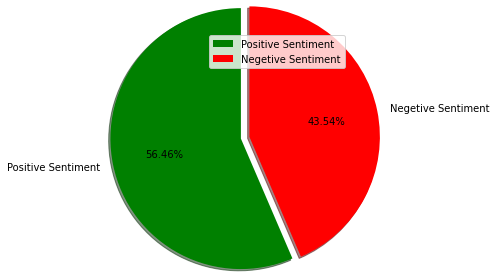

In [12]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## 2.2) Most used positive words

<Figure size 3600x2400 with 0 Axes>

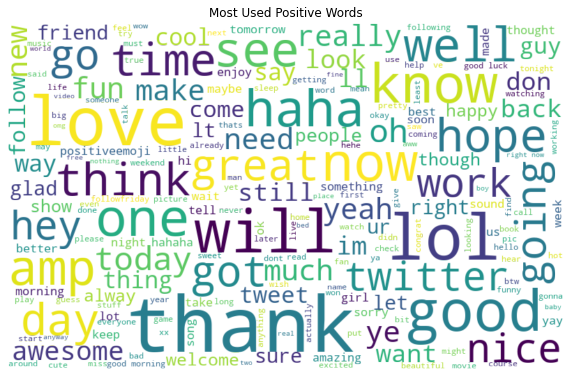

In [13]:
positive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
plt.savefig('assets/positive_words.png')
plt.show()

## 2.3) Most used negetive words

<Figure size 3600x2400 with 0 Axes>

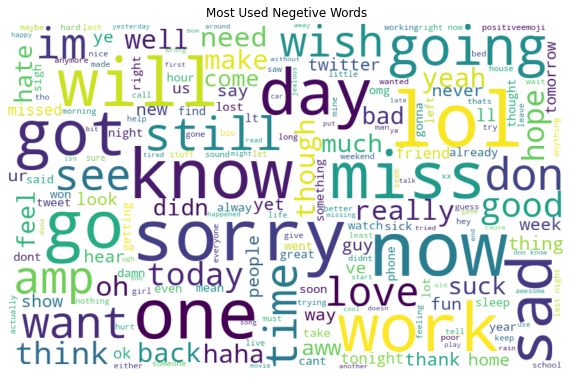

In [14]:
negetive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, 
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negetive Words")
plt.savefig('assets/negetive_words.png')
plt.show()

#### See the word `lol`. It is used both in positive and negetive(sarcastic) sentiments. We still can't classify sarcasm.

# 3) Feature extraction (vectorization)

## N-grams included (Unigram, Bigram, Trigram)

`check this article on` **[How to Prepare Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)**

`check this article on` **[countvectorizer and tf-idf](https://www.kaggle.com/divsinha/sentiment-analysis-countvectorizer-tf-idf)**

*Tf-idf* is different from *CountVectorizer*. *CountVectorizer* gives equal weightage to all the words, i.e. a word is converted to a column (in a dataframe for example) and for each document, it is equal to 1 if it is present in that doc else 0. 
Apart from giving this information, *Tf-idf* says how important that word is to that document with respect to the corpus.

## 3.1) Count vectorizer

As we all know, all machine learning algorithms are good with numbers; we have to extract or convert the text data into numbers without losing much of the information. One way to do such transformation is *Bag-Of-Words (BOW)* which gives a number to each word but that is very inefficient. So, a way to do it is by *CountVectorizer*: it counts the number of words in the document i.e it converts a collection of text documents to a matrix of the counts of occurences of each word in the document.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(total_data['processed_tweet'])  
final_vectorized_data

<99989x455478 sparse matrix of type '<class 'numpy.int64'>'
	with 2112514 stored elements in Compressed Sparse Row format>

## 3.2) Tf-Idf vectorizer

*TF-IDF (stands for Term-Frequency-Inverse-Document Frequency)* weights down the common words occuring in almost all the documents and give more importance to the words that appear in a subset of documents. *TF-IDF* works by penalising these common words by assigning them lower weights while giving importance to some rare words in a particular document. ***Rare terms are more informative than frequent terms.***

![](assets/tfidf.png)

<br/>

**The below code is commented out because *CountVectorizer* gives better accuracy in this sentiment analysis than *tf-idf*. If you want to check, then uncomment the code below, comment the countVectorizer code above and run the whole code again.**  
<br/>  


In [24]:
# from sklearn.feature_extraction.text import TfidfVectorizer 

# tf_idf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
# final_vectorized_data = tf_idf_vectorizer.fit_transform(total_data['processed_tweet'])

# final_vectorized_data

# 4) Splitting

##### Splitting train data to test accuracy

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)  

##### Printing splitted dataset sizes

In [24]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (79991, 455478)
X_test_shape :  (19998, 455478)
y_train_shape :  (79991,)
y_test_shape :  (19998,)


# 5) Train and predict

## 5.1) Naive_bayes

### Bayes theorem :
![](assets/bayes_formula.jpg)

### There are some popular classifiers under Naive Bayes
* **Bernoulli Naive Bayes**
* **Gaussian Naive Bayes classifier**
* **Multinomial Naive Bayes**

#### We will use Multinomial Naive Bayes classifier

In [17]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


NameError: name 'x_train' is not defined

##### Print Confusion matrix

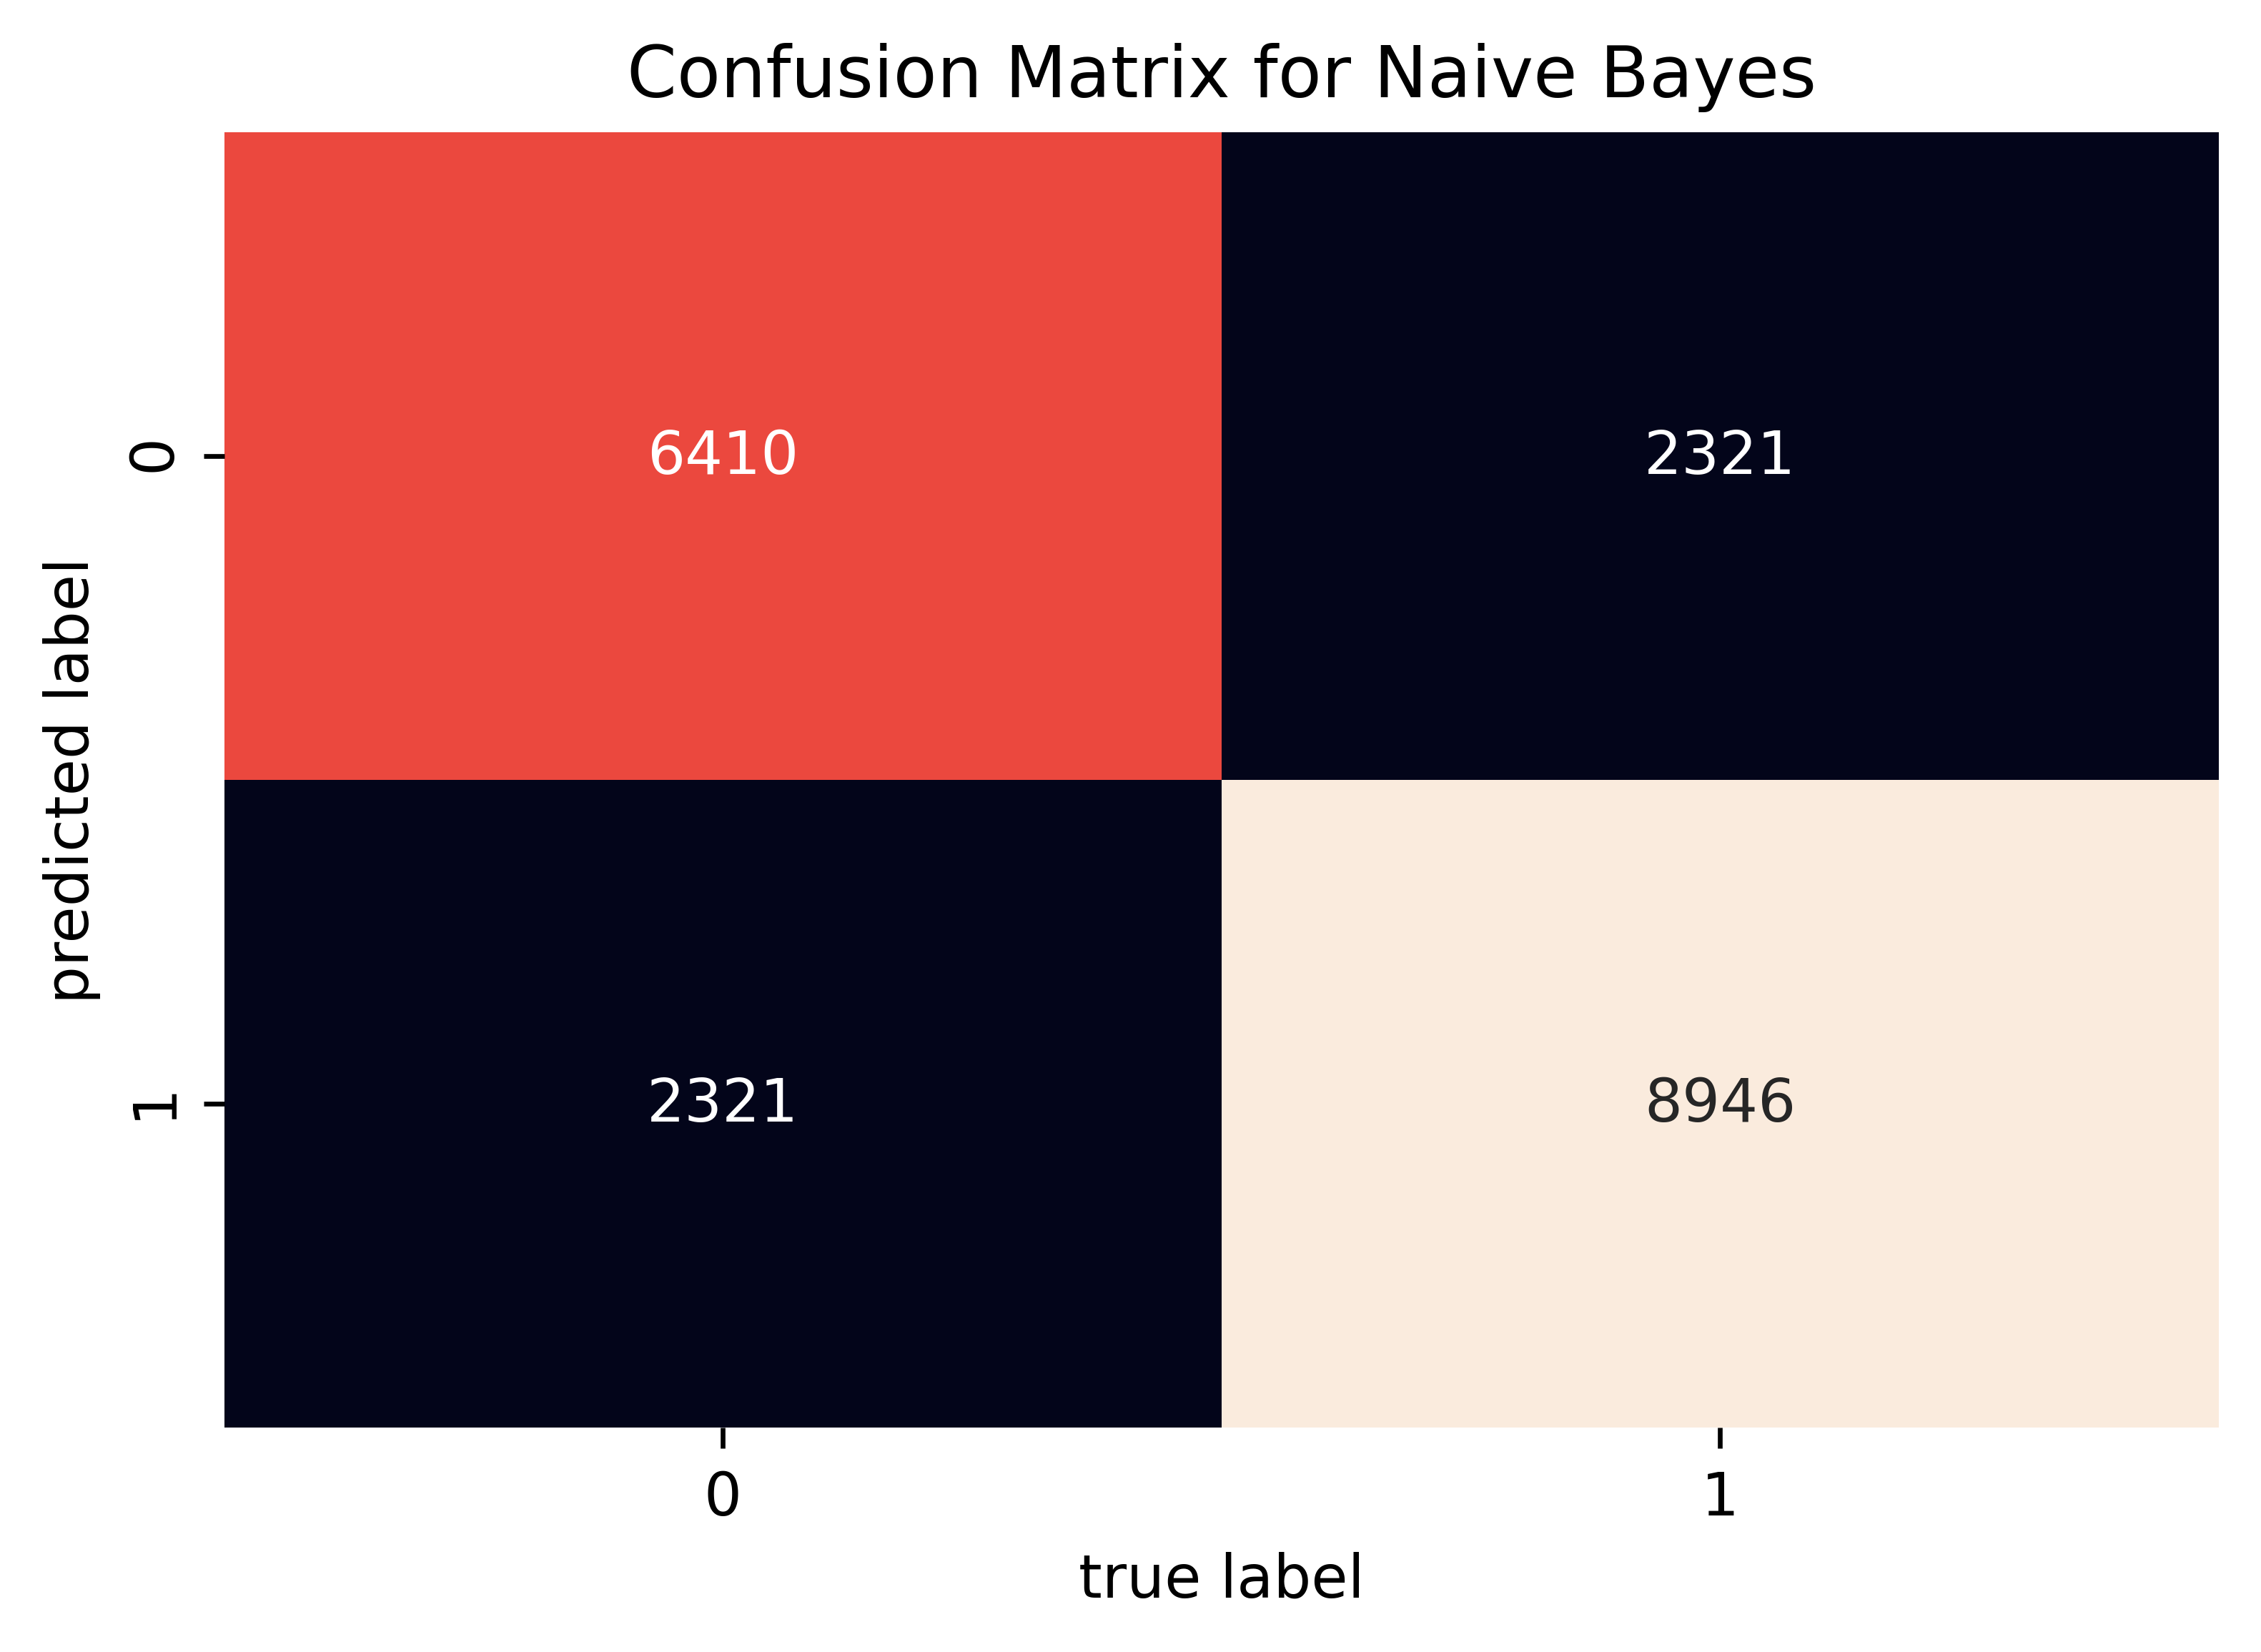

In [18]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=600)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("assets/confusion_matrix.png")
plt.show()

## Find out accuracy of our prediction

In [27]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)

Accuracy with Naive-bayes:  0.7678767876787679


# 6) Precision, Recall, and Accuracy

##### Precision, recall, and accuracy are standard metrics used to evaluate the performance of a classifier.

* Precision measures how many texts were predicted correctly as belonging to a given category out of all of the texts that were predicted (correctly and incorrectly) as belonging to the category.

* Recall measures how many texts were predicted correctly as belonging to a given category out of all the texts that should have been predicted as belonging to the category. We also know that the more data we feed our classifiers with, the better recall will be.

* Accuracy measures how many texts were predicted correctly (both as belonging to a category and not belonging to the category) out of all of the texts in the corpus.

##### Most frequently, precision and recall are used to measure performance since accuracy alone does not say much about how good or bad a classifier is.

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8731
           1       0.79      0.79      0.79     11267

    accuracy                           0.77     19998
   macro avg       0.76      0.76      0.76     19998
weighted avg       0.77      0.77      0.77     19998



`Check this link to learn` **[ROC, precision & recall curves](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)**

### Drawing ROC curve

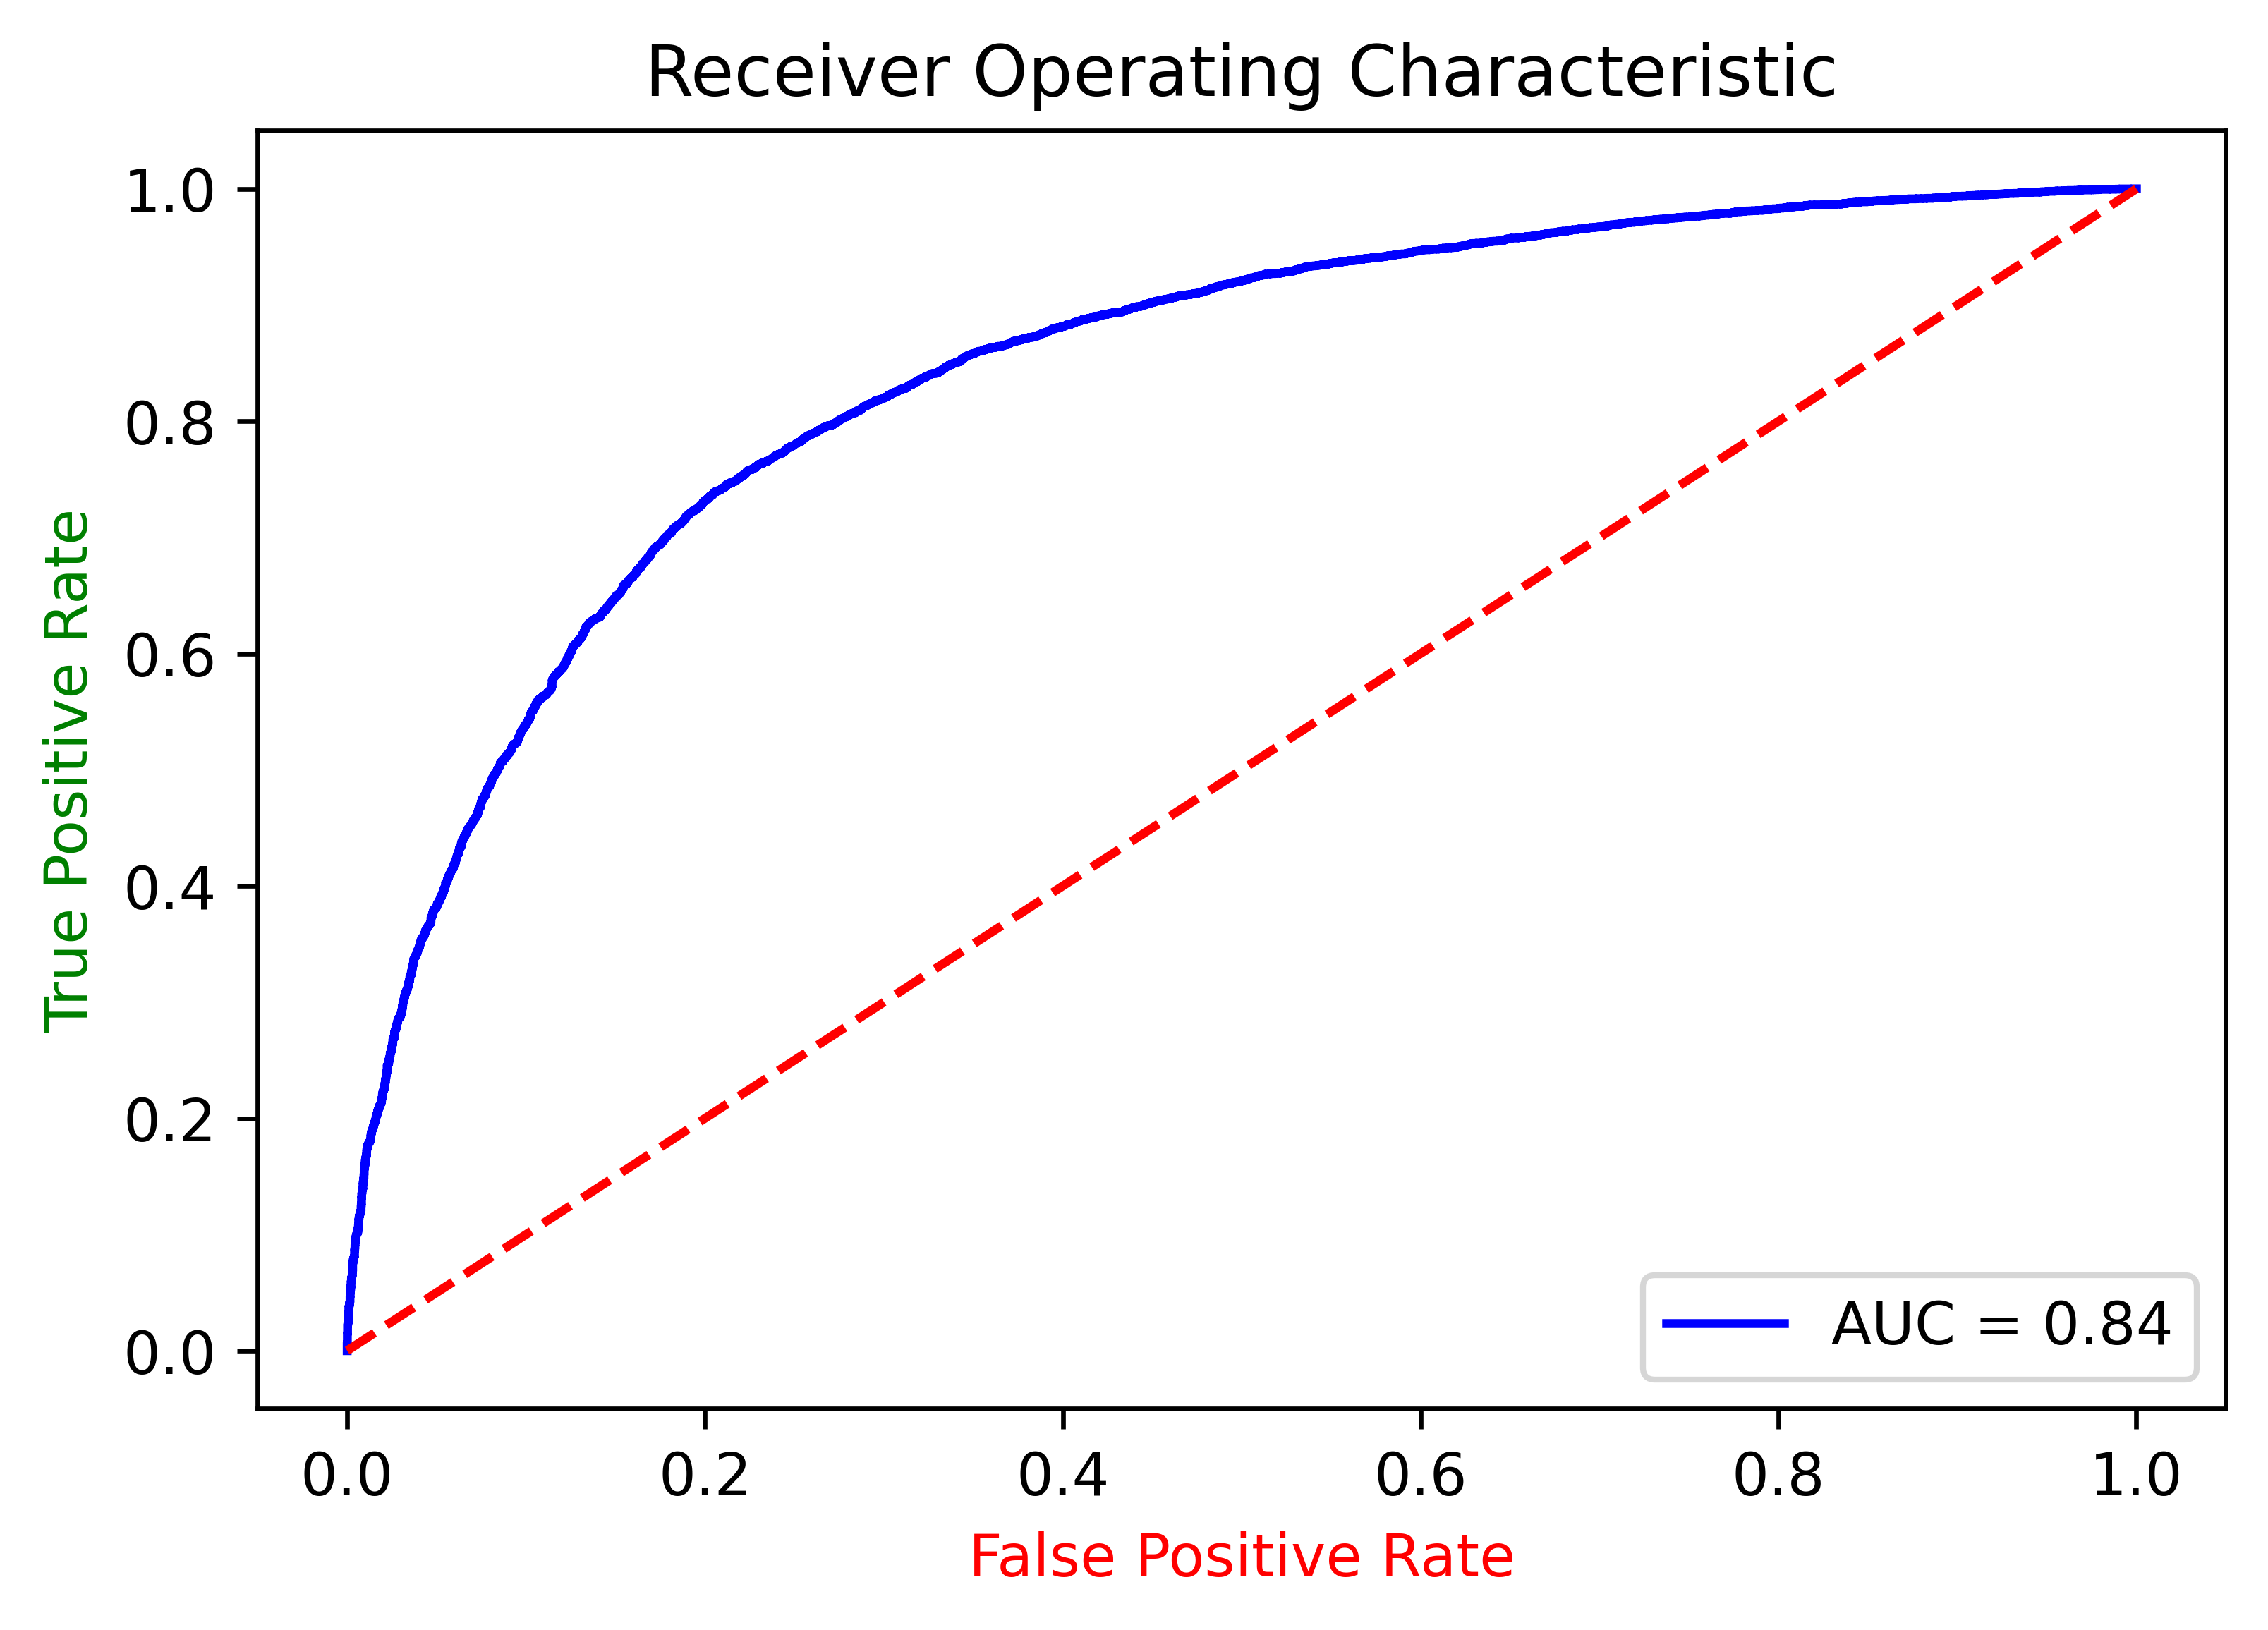

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=600)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.savefig("assets/ROC_curve.png")
plt.show()

***Area Under the Curve of anything greater than `0.80` with real life data is not bad***

# 7) Results  (Accuracy)

## 7.1) With CountVectorizer

|   Accuracy Table   	|      Stemming      	|     Lemmatizing    	|
|:------------------:	|:------------------:	|:------------------:	|
| Without Stop Words 	|  0.755025502550255 	|  0.757025702570257 	|
|   With Stop Words  	| 0.7477747774777478 	| 0.7483748374837483 	|

## 7.2) With Tf-Idf Vectorizer

|   Accuracy Table   	|      Stemming      	|     Lemmatizing    	|
|:------------------:	|:------------------:	|:------------------:	|
| Without Stop Words 	| 0.7435743574357436 	| 0.7403740374037404 	|
|   With Stop Words  	| 0.7383738373837384 	| 0.7456245624562456 	|

# 8) Conclusion

*Here we can see this is the hierarchy of accuracy rate of 3 combinations (Vectorizer, stop words, normalization). Sorted as Decreasing order of accuracy.*



| Normalization 	| Stop Words 	| Vectorizer 	|      Accuracy      	|
|:-------------:	|:----------:	|:----------:	|:------------------:	|
|     None        	|     No     	|    Count   	| 0.7601260126012601 	|
|  Lemmatizing  	|     No     	|    Count   	|  0.757025702570257 	|
|    Stemming   	|     No     	|    Count   	|  0.755025502550255 	|
|  Lemmatizing  	|     Yes    	|    Count   	| 0.7483748374837483 	|
|     None        	|     No     	|   Tf-Idf   	| 0.7480748074807481 	|
|    Stemming   	|     Yes    	|    Count   	| 0.7477747774777478 	|
|  Lemmatizing  	|     Yes    	|   Tf-Idf   	| 0.7456245624562456 	|
|    Stemming   	|     No     	|   Tf-Idf   	| 0.7435743574357436 	|
|  Lemmatizing  	|     No     	|   Tf-Idf   	| 0.7403740374037404 	|
|    Stemming   	|     Yes    	|   Tf-Idf   	| 0.7383738373837384 	|

### So here we see the best combination for sentiment analysis with this dataset is using
* **Without normalization**
* **Without stop words**
* **Count Vectorizer**
* **Unigrams and Bigrams**

***Leaderboard Highest : 0.79249***  
***This Naive model : 0.76788***

*For document analysis the best combination will include lemmatization, stop words, but in sentiment analysis, they aren't providing edge over the raw datas.*

# 9) Acknowledgements

#### Datasets taken from
* **[Kaggle Twitter dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data)**


#### Must Read
* **[Towards Data Science](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)**
* **[Analytics Vidya](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)**
* **[Project report on Github](https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/docs/report.pdf)**
* **[Medium](https://medium.com/@martinpella/naive-bayes-for-sentiment-analysis-49b37db18bf8)**
* **[Stackabuse](https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/)**
* **[Geeksforgeeks](https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/)**